# Introduction

I love Neural Networks! Neural networks are used in a wide variety of applications in pattern classification, language processing, complex systems modeling, control, optimization, and prediction [1]. NNs are the underlying motor behind the advances in computer vision. With computer vision, we can do things like detect tumors in CT scans or detect pupils of an individual in an image. The objective of this project is to detect the center of the pupil in the image of an eye. 

While detecting the center of the pupil, I will make changes to the hyperparameters of the NN to obtain a better comprehension of the mechanics of a NN. Such changes include increasing/decreasing the size of the dataset and increasing/decreasing the batch size. I will also study the robustness of the network with respect to changes in the images, with the changes being turning the image to black-and-white as well as adding black spots to image to create noise. Along with the study of the influence of hyperparameters and study of robustness, I will also plot the actual X vs. the predicted X, as well as the actual Y vs. the predicted Y while using the difference between the actual X and predicted X, as well as the difference between the actual Y and predicted Y as the measure of accuracy. 

I hypothesize that increasing the size of the dataset will increase the accuracy of the NN and increase the runtime, whereas decreasing the size of the dataset will lead to a decrease in accuracy and runtime. As for the batch size, I believe that increasing the size of the batches will result in higher accuracy, but longer runtime whereas decreasing the batch size will lead to lower accuracy and shorter runtime. When it comes to the study of robustness, I believe removing the skin color from the image will result in an increase in accuracy whereas adding noise will only decrease the accuaracy. On the other hand, I believe that adding noise to the image will cause the accuracy to decrease with the runtime remaining unchanged for both.

# CODE!!!

In [323]:
# Adapted from Adrian Rosebrock https://www.pyimagesearch.com/2019/01/28/keras-regression-and-cnns/

# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

# build the network

def create_cnn(width, height, depth, nfilters=(16, 32, 64), regress=False):
    # initialize the input shape and channel dimension, assuming
    # TensorFlow/channels-last ordering
    inputShape = (height, width, depth)
    chanDim = -1

    # define the model input
    inputs = Input(shape=inputShape)

    # loop over the number of filters
    for (i, nf) in enumerate(nfilters):
        # if this is the first CONV layer then set the input
        # appropriately
        if i == 0:
            x = inputs

        # CONV => RELU => BN => POOL
        x = Conv2D(nf, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=chanDim)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)

    # flatten the volume, then FC => RELU => BN => DROPOUT
    x = Flatten()(x)
    x = Dense(16)(x)
    x = Activation("relu")(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Dropout(0.5)(x)

    # apply another FC layer: JR not sure what the role of this is
    x = Dense(4)(x)
    x = Activation("relu")(x)

    x = Dense(2, activation="linear")(x)    ################  2D output

    # construct the CNN
    model = Model(inputs, x)

    # return the CNN
    return model



In [324]:
import glob
import cv2


def load_images(df, inputPath):
    # return np.array of images (cv2.imread), slicing off opacity layer if needed 
	# optionally resize images with cv2.resize
    
    #initialize our images array
    images = []
    
    # loop over the indexes of the houses
    eyepaths = sorted(list(glob.glob(inputPath + '/*.png')))

    for path in eyepaths:        
        image = cv2.imread(path)  
        image = cv2.resize(image, (32,32))
        images.append(image)


    return np.array(images)


In [325]:
import pandas as pd
def load_attributes(inputPath):
	# return dataframe of attributes we want to predict
    df = pd.read_csv(inputPath, sep=' ').copy()
    
    return df

# now actually do it

In [326]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt

datafolder = 'one_eye'
datafile   = 'one_eye.txt'
# construct the path to the input .txt file that contains information
# on each image in the dataset and then load the dataset
print("Loading attributes...")
inputPath = os.path.sep.join([datafolder, datafile]) 
df = load_attributes(inputPath)


Loading attributes...


In [327]:
# load the images and then scale the pixel intensities to the
# range [0, 1]
print("Loading images...")
images = load_images(df, datafolder)
images = images / 255.0

Loading images...


In [328]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:1000], images[:1000], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=8)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)


Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 18s 24ms/step - loss: 0.9466 - val_loss: 0.4583
Epoch 2/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3800 - val_loss: 0.5696
Epoch 3/10
750/750 [==============================] - 4s 6ms/step - loss: 0.2685 - val_loss: 0.4700
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.2094 - val_loss: 0.3661
Epoch 5/10
750/750 [==============================] - 4s 5ms/step - loss: 0.1880 - val_loss: 0.3871
Epoch 6/10
750/750 [==============================] - 4s 5ms/step - loss: 0.1555 - val_loss: 0.2579
Epoch 7/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1548 - val_loss: 0.1586
Epoch 8/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1544 - val_loss: 0.0929
Epoch 9/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1384 - val_loss: 0.0747
Epoch 10/10
750/750 [=============

It seems that the NN is running at approximately 4s per epoch with the batch size equal to 8 and evaluating the whole dataset.

In order to evaluate accuracy, I shall use the average distance between the predicted center and actual center to determine how far off the NN is from finding the center of the pupil

In [329]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [330]:
print(avg_distance_x, avg_distance_y)

0.15875247944736479 0.2218186558895112


This shows that the average distance of seperation between the predicted point and the actual point is 0.15975 between along the x-axis and .22182 between the y-axis when we utilize the full training data.

Text(0.5, 1.0, 'Distances along the x-axis')

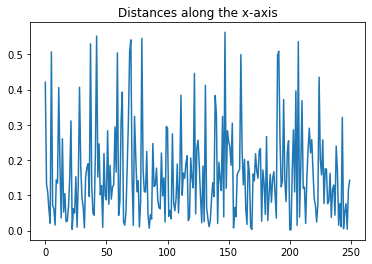

In [331]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

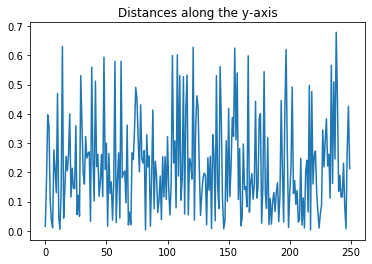

In [332]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

It seems to me that there is more variablility in the differences between the y-axis. This is due to the fact that there are more peaks in the plot for the y-axis differences.

# Testing changes in the size of the training/test set

In [338]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:500], images[:500], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=8)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)



Training model...
Train on 375 samples, validate on 125 samples
Epoch 1/10
375/375 [==============================] - 18s 49ms/step - loss: 0.7194 - val_loss: 0.4546
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.3957 - val_loss: 0.8638
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2609 - val_loss: 3.5593
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.2146 - val_loss: 7.0615
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1685 - val_loss: 9.5530
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1705 - val_loss: 7.0359
Epoch 7/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1624 - val_loss: 3.2685
Epoch 8/10
375/375 [==============================] - 3s 7ms/step - loss: 0.1402 - val_loss: 1.6825
Epoch 9/10
375/375 [==============================] - 2s 6ms/step - loss: 0.1291 - val_loss: 0.4983
Epoch 10/10
375/375 [=============

Decreasing the training set size by one-half will lead to the NN running faster by twice as fast, taking up half the amount of time with the same batch size.

In [339]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [340]:
print(avg_distance_x, avg_distance_y)

0.43713774012184115 0.26247984196586616


This shows that the average distance of seperation between the predicted point and the actual point is 0.43714 between along the x-axis and 0.26248 between the y-axis when we utilize the full training data.

Text(0.5, 1.0, 'Distances along the x-axis')

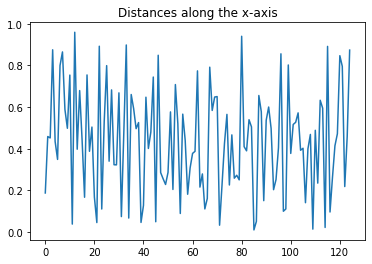

In [341]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

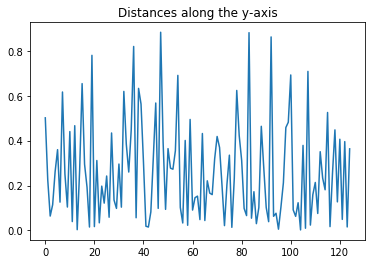

In [342]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

By decreasing the training size, I have found that the accuracy decreases because the distance between the two points increases. The lack of training examples leads the NN to being less accurate because it has less examples to learn from.

In [347]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:50], images[:50], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=8)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 37 samples, validate on 13 samples
Epoch 1/10
37/37 [==============================] - 15s 419ms/step - loss: 1.4525 - val_loss: 0.4853
Epoch 2/10
37/37 [==============================] - 0s 7ms/step - loss: 1.2547 - val_loss: 0.4279
Epoch 3/10
37/37 [==============================] - 0s 8ms/step - loss: 1.3852 - val_loss: 0.3578
Epoch 4/10
37/37 [==============================] - 0s 6ms/step - loss: 1.1458 - val_loss: 0.3117
Epoch 5/10
37/37 [==============================] - 0s 7ms/step - loss: 1.2568 - val_loss: 0.2961
Epoch 6/10
37/37 [==============================] - 0s 6ms/step - loss: 0.7711 - val_loss: 0.2725
Epoch 7/10
37/37 [==============================] - 0s 7ms/step - loss: 0.6274 - val_loss: 0.2625
Epoch 8/10
37/37 [==============================] - 0s 7ms/step - loss: 0.5530 - val_loss: 0.2669
Epoch 9/10
37/37 [==============================] - 0s 6ms/step - loss: 0.6187 - val_loss: 0.2885
Epoch 10/10
37/37 [==============================] - 

With a very small dataset, the NN runs in less than a second by using a fraction of the dataset. I believe the repurcusion of this to be a decrease in accuracy.

In [348]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [349]:
print(avg_distance_x, avg_distance_y)

0.6324488949775695 0.3230423141259413


Text(0.5, 1.0, 'Distances along the x-axis')

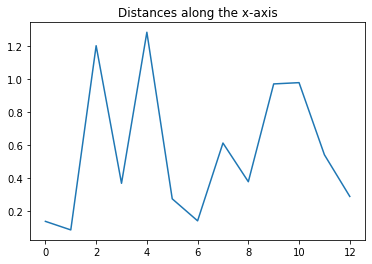

In [275]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

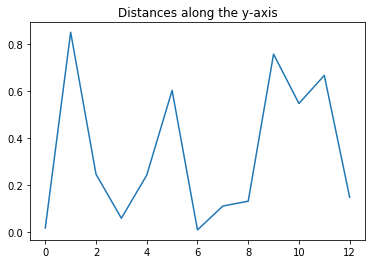

In [276]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

Decreasing the training size even more causes the accuracy to decrease even more.

I also tested increasing the number of filters in the layers which causes the NN to slow down (potentially causing the computer to freeze). Likewise, decreasing the number of filters leads to the NN speeding up.

## Increasing/Decreasing the Batch size

Along with testing the training size and the number of filters, I also decided to see how changing the Batch Size might affect the accuracy and speed

In [360]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:1000], images[:1000], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=10)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 23s 31ms/step - loss: 1.3877 - val_loss: 0.5458
Epoch 2/10
750/750 [==============================] - 5s 6ms/step - loss: 0.6783 - val_loss: 0.5040
Epoch 3/10
750/750 [==============================] - 5s 6ms/step - loss: 0.4501 - val_loss: 2.6744
Epoch 4/10
750/750 [==============================] - 5s 6ms/step - loss: 0.3469 - val_loss: 6.5244
Epoch 5/10
750/750 [==============================] - 5s 6ms/step - loss: 0.3100 - val_loss: 1.4866
Epoch 6/10
750/750 [==============================] - 5s 6ms/step - loss: 0.2556 - val_loss: 0.2314
Epoch 7/10
750/750 [==============================] - 5s 6ms/step - loss: 0.2305 - val_loss: 0.1945
Epoch 8/10
750/750 [==============================] - 5s 6ms/step - loss: 0.2065 - val_loss: 0.1784
Epoch 9/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1903 - val_loss: 0.1563
Epoch 10/10
750/750 [=============

In [361]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [362]:
print(avg_distance_x, avg_distance_y)

0.2680503152093889 0.3313188182184219


Text(0.5, 1.0, 'Distances along the x-axis')

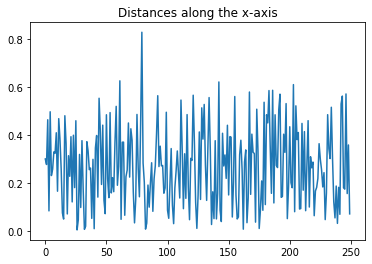

In [363]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

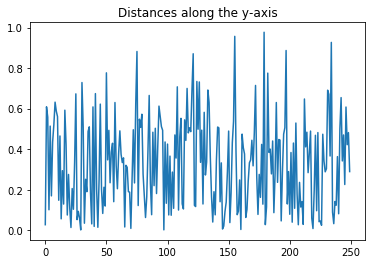

In [364]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

Increasing the Batch size to 10 slows the NN down and also decreases the accuracy. 

In [365]:
# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=15)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1569 - val_loss: 0.1017
Epoch 2/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1430 - val_loss: 0.0934
Epoch 3/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1447 - val_loss: 0.0813
Epoch 4/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1342 - val_loss: 0.0834
Epoch 5/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1433 - val_loss: 0.0701
Epoch 6/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1351 - val_loss: 0.0636
Epoch 7/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1224 - val_loss: 0.0587
Epoch 8/10
750/750 [==============================] - 4s 5ms/step - loss: 0.1302 - val_loss: 0.0593
Epoch 9/10
750/750 [==============================] - 4s 5ms/step - loss: 0.1161 - val_loss: 0.0526
Epoch 10/10
750/750 [===============

In [366]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [367]:
print(avg_distance_x, avg_distance_y)

0.1339038460310936 0.19583625592765802


Text(0.5, 1.0, 'Distances along the x-axis')

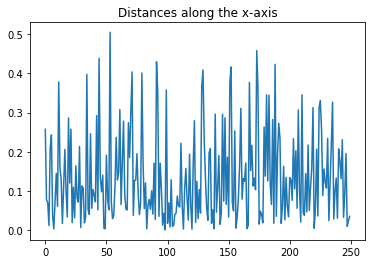

In [368]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

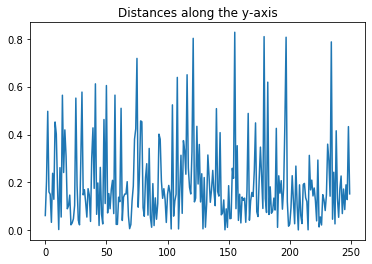

In [369]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

However, increasing the batch size to 15 leads to a decrease in run time and a notable increase in accuracy. I noticed that the initial epoch processed significantly faster than the prior NN run as well as the original run.

In [381]:
# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=30)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1408 - val_loss: 0.0781
Epoch 2/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1301 - val_loss: 0.0698
Epoch 3/10
750/750 [==============================] - 3s 5ms/step - loss: 0.1248 - val_loss: 0.0629
Epoch 4/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1252 - val_loss: 0.0598
Epoch 5/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1196 - val_loss: 0.0581
Epoch 6/10
750/750 [==============================] - 3s 5ms/step - loss: 0.1128 - val_loss: 0.0566
Epoch 7/10
750/750 [==============================] - 3s 5ms/step - loss: 0.1132 - val_loss: 0.0559
Epoch 8/10
750/750 [==============================] - 3s 5ms/step - loss: 0.1022 - val_loss: 0.0550
Epoch 9/10
750/750 [==============================] - 3s 4ms/step - loss: 0.1132 - val_loss: 0.0536
Epoch 10/10
750/750 [===============

In [382]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [383]:
print(avg_distance_x, avg_distance_y)

0.12288710605506899 0.21554187125835425


Text(0.5, 1.0, 'Distances along the x-axis')

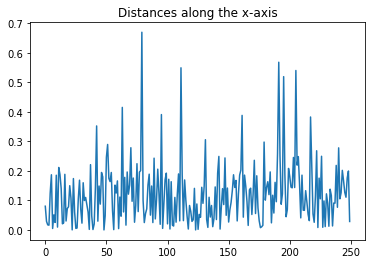

In [384]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

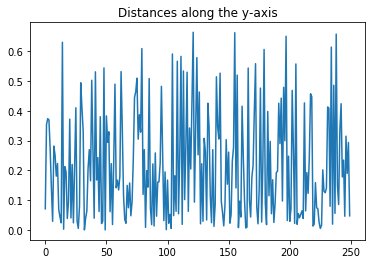

In [385]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

Increasing the batch size even further led to a decrease in accuracy but also a decrease in run time. This implies that there is an optimal batch size somewhere between 30 and 15 batches. However, when it comes to loss and value loss, the loss seems to be lowest when the NN is ran with 15 training batches. 

In [386]:
# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=5)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1321 - val_loss: 0.0593
Epoch 2/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1238 - val_loss: 0.0439
Epoch 3/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1162 - val_loss: 0.0327
Epoch 4/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1148 - val_loss: 0.0269
Epoch 5/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1125 - val_loss: 0.0277
Epoch 6/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1035 - val_loss: 0.0213
Epoch 7/10
750/750 [==============================] - 5s 7ms/step - loss: 0.1084 - val_loss: 0.0198
Epoch 8/10
750/750 [==============================] - 6s 7ms/step - loss: 0.1012 - val_loss: 0.0201
Epoch 9/10
750/750 [==============================] - 6s 8ms/step - loss: 0.1068 - val_loss: 0.0309
Epoch 10/10
750/750 [===============

In [387]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [388]:
print(avg_distance_x, avg_distance_y)

0.11151490394525528 0.11111463105983735


Text(0.5, 1.0, 'Distances along the x-axis')

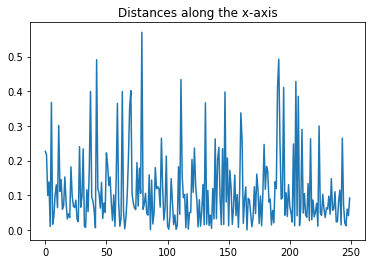

In [389]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

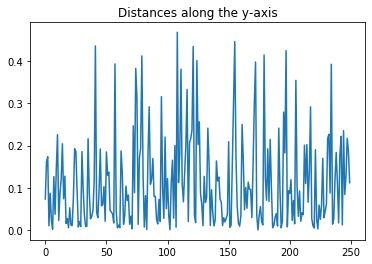

In [390]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

It is notable that decreasing the batch size to 5 increased accuracy but also led to an increase in run time. With regards to accuracy, this may be the most optimal network.

In [391]:
# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=2)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 10s 13ms/step - loss: 0.1911 - val_loss: 0.3865
Epoch 2/10
750/750 [==============================] - 10s 13ms/step - loss: 0.1816 - val_loss: 0.2022
Epoch 3/10
750/750 [==============================] - 10s 14ms/step - loss: 0.2051 - val_loss: 0.1292
Epoch 4/10
750/750 [==============================] - 10s 14ms/step - loss: 0.1755 - val_loss: 0.0807
Epoch 5/10
750/750 [==============================] - 10s 13ms/step - loss: 0.1529 - val_loss: 0.1847
Epoch 6/10
750/750 [==============================] - 10s 14ms/step - loss: 0.1445 - val_loss: 0.3330
Epoch 7/10
750/750 [==============================] - 10s 14ms/step - loss: 0.1487 - val_loss: 0.2212
Epoch 8/10
750/750 [==============================] - 11s 14ms/step - loss: 0.1400 - val_loss: 0.2444
Epoch 9/10
750/750 [==============================] - 11s 14ms/step - loss: 0.1369 - val_loss: 0.2794
Epoch 10/10
750/75

In [392]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [393]:
print(avg_distance_x, avg_distance_y)

0.4964075270106319 0.20910349167900086


Text(0.5, 1.0, 'Distances along the x-axis')

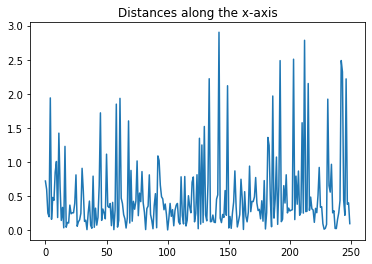

In [394]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

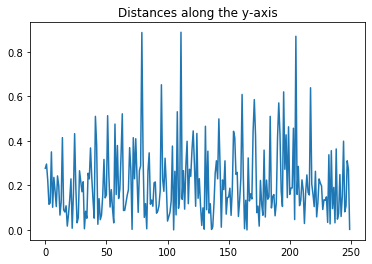

In [395]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

Decreasing the batch size to 2 causes a significant loss in accuracy and increase in run time. The value losses are also a notable impediment in this iteration. It also seems that the NN becomes more precise with smaller batches, deriving this conclusion from the fact that there are lower peaks in the plot for batch size equal to 2 and 5.

# Robustness

In order to test robustness I will first be converting the image to a black and white image. Following that I shall add noise to the image by converting random pixels in the image to black.

## Black and White

In [396]:
import glob
import cv2


def load_images(df, inputPath):
    # return np.array of images (cv2.imread), slicing off opacity layer if needed 
	# optionally resize images with cv2.resize
    
    #initialize our images array
    images = []
    
    # loop over the indexes of the houses
    eyepaths = sorted(list(glob.glob(inputPath + '/*.png')))

    for path in eyepaths:        
        image = cv2.imread(path)  
        image = cv2.resize(image, (32,32))
        for row in range(len(image)):
                for pixel in range(len(image[row])):
                    for val in range(len(image[row][pixel])): 
                        if val > 50:
                            image[row][pixel][val] = 255
        images.append(image)


    return np.array(images)


In [397]:
import pandas as pd
def load_attributes(inputPath):
	# return dataframe of attributes we want to predict
    df = pd.read_csv(inputPath, sep=' ').copy()
    
    return df

# now actually do it

In [398]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt

datafolder = 'one_eye'
datafile   = 'one_eye.txt'
# construct the path to the input .txt file that contains information
# on each image in the dataset and then load the dataset
print("Loading attributes...")
inputPath = os.path.sep.join([datafolder, datafile]) 
df = load_attributes(inputPath)


Loading attributes...


In [399]:
# load the images and then scale the pixel intensities to the
# range [0, 1]
print("Loading images...")
images = load_images(df, datafolder)
images = images / 255.0

Loading images...


In [400]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:1000], images[:1000], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=8)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 21s 28ms/step - loss: 0.8013 - val_loss: 2.0201
Epoch 2/10
750/750 [==============================] - 4s 6ms/step - loss: 0.4746 - val_loss: 4.6505
Epoch 3/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3308 - val_loss: 3.4442
Epoch 4/10
750/750 [==============================] - 4s 6ms/step - loss: 0.2652 - val_loss: 0.8471
Epoch 5/10
750/750 [==============================] - 4s 6ms/step - loss: 0.2116 - val_loss: 0.6337
Epoch 6/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1677 - val_loss: 0.1003
Epoch 7/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1616 - val_loss: 0.0656
Epoch 8/10
750/750 [==============================] - 4s 6ms/step - loss: 0.1288 - val_loss: 0.0446
Epoch 9/10
750/750 [==============================] - 5s 6ms/step - loss: 0.1203 - val_loss: 0.1657
Epoch 10/10
750/750 [=============

In [401]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [402]:
print(avg_distance_x, avg_distance_y)

0.161937022325039 0.1888497147994995


Text(0.5, 1.0, 'Distances along the x-axis')

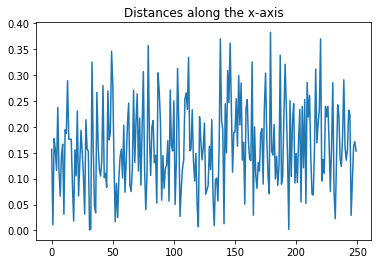

In [403]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

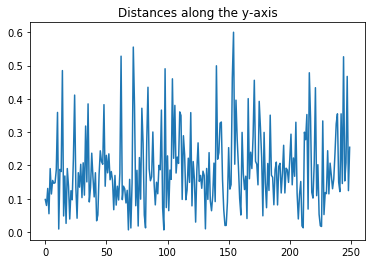

In [404]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

It seems that removing the skin color from the image led to an increase in accuracy, a reduction in loss, and decrease in runtime, compared to the original run time. This implies that removing unncecessary features leads to an improvement in performance.

## Adding Noise

In [405]:
import glob
import cv2


def load_images(df, inputPath):
    # return np.array of images (cv2.imread), slicing off opacity layer if needed 
	# optionally resize images with cv2.resize
    
    #initialize our images array
    images = []
    
    # loop over the indexes of the houses
    eyepaths = sorted(list(glob.glob(inputPath + '/*.png')))

    for path in eyepaths:        
        image = cv2.imread(path)  
        image = cv2.resize(image, (32,32))
        for row in range(len(image)):
            for rand in range(4):
                image[np.random.randint(0,high=31)] = np.zeros(3)
        images.append(image)


    return np.array(images)

In order to add noise to the image, I decided to set 4 random pixels in each row to be black which is the same color as the pupil

In [406]:
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import numpy as np
import os
import matplotlib.pyplot as plt

datafolder = 'one_eye'
datafile   = 'one_eye.txt'
# construct the path to the input .txt file that contains information
# on each image in the dataset and then load the dataset
print("Loading attributes...")
inputPath = os.path.sep.join([datafolder, datafile]) 
df = load_attributes(inputPath)


Loading attributes...


In [407]:
# load the images and then scale the pixel intensities to the
# range [0, 1]
print("Loading images...")
images = load_images(df, datafolder)
images = images / 255.0

Loading images...


In [408]:
images.shape

(1000, 32, 32, 3)

In [409]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
split = train_test_split(df[:1000], images[:1000], test_size=0.25, random_state=42)   # can alternatively make your own function to do this
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

# scale and shift the data into [0,1]
trainY = trainAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!
testY  =  testAttrX[['x','y']].values / np.array([40,20]) + 0.5	# map into [0,1]  ##### ad hoc here, needs to be modified!

# create our Convolutional Neural Network and then compile the model
# using mean squared error as our loss

model = create_cnn(32,32, 3, regress=True)
opt = Adam(lr=1e-3, decay=1e-3 / 200)  # more sophisticated than plain gradient descent
model.compile(loss="mean_squared_error", optimizer=opt)

# train the model
print("Training model...")
model.fit(trainImagesX, trainY, validation_data=(testImagesX, testY),
        epochs=10, batch_size=8)

model.save('model.h5')  # in case we want to take up training from were we left off

# make predictions on the testing data
print("Predicting ...")
preds = model.predict(testImagesX)

Training model...
Train on 750 samples, validate on 250 samples
Epoch 1/10
750/750 [==============================] - 22s 29ms/step - loss: 1.1237 - val_loss: 0.4342
Epoch 2/10
750/750 [==============================] - 4s 5ms/step - loss: 0.7023 - val_loss: 0.3960
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 0.5240 - val_loss: 0.3699
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.4459 - val_loss: 0.3260
Epoch 5/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3936 - val_loss: 0.3073
Epoch 6/10
750/750 [==============================] - 5s 6ms/step - loss: 0.3775 - val_loss: 0.3074
Epoch 7/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3588 - val_loss: 0.3055
Epoch 8/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3385 - val_loss: 0.2982
Epoch 9/10
750/750 [==============================] - 4s 6ms/step - loss: 0.3250 - val_loss: 0.2907
Epoch 10/10
750/750 [=============

In [410]:
#calculate distance between points
preds, testY = np.array(preds), np.array(testY)
distanceX = np.absolute(preds[:,0] - testY[:,0])
avg_distance_x = sum(distanceX)/len(distanceX)
distanceY = np.absolute(preds[:,1] - testY[:,1])
avg_distance_y = sum(distanceY)/len(distanceY)

In [411]:
print(avg_distance_x, avg_distance_y)

0.5389942308546063 0.3799845250377656


Text(0.5, 1.0, 'Distances along the x-axis')

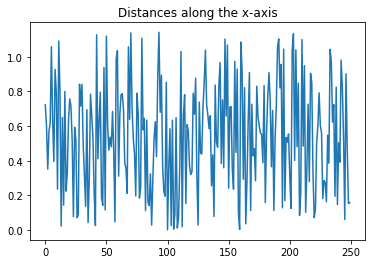

In [412]:
plt.plot(distanceX)
plt.title('Distances along the x-axis')

Text(0.5, 1.0, 'Distances along the y-axis')

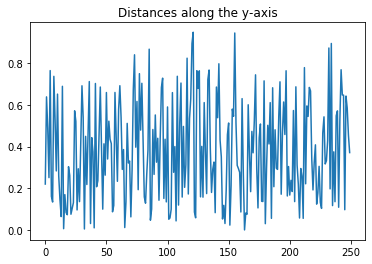

In [413]:
plt.plot(distanceY)
plt.title('Distances along the y-axis')

By adding noise to the image, I find that it definitely affects the accuracy of the NN. The accuracy decreased when compared to the initial run of the NN. The loss increased significantly in the epochs of the NN as well. However, the run time was unaltered.

# Conclusion

With regards to the hyperparameters, I have found that increasing the size of the dataset does, in fact, lead to a higher degree of accuracy as well as increasing the runtime. Also, Decreasing the size of the dataset does lead to a decrease in accuracy and runtime. I believe this to be due to the fact that training on more data gives more examples to learn from. I also found that the information loss decreases with respect to the size of the dataset. When it comes to batch size, larger batch sizes tend to perform better than smaller batch sizes but they do so with less precision. I have also found that, in regards to the loss of information through the networks, the loss function follows a parabolic trajectory, implying that there is a minimum along the trajectory where the loss function is optimized.

In terms of the study of robustness, I have found that removing redundant information, aka noise, leads to better performance with respect to accuracy and precision, but has no affect on runtime. It also leads to a significant decrease in the loss function. When we add noise, on the other hand, it turns out that as the amount of noise increases, the accuracy and precision decrease. More noise also leads to much more loss when compared to the original iteration. Finally, noise has no affect on runtime whatsoever.

# References

[1] Neural Networks an overview. sciencedirect.com. https://www.sciencedirect.com/topics/neuroscience/neural-networks